In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import tqdm
import glob
import urllib.request
import torchvision
import torch
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from torchvision import transforms
import tqdm
import pickle


%matplotlib inline

In [3]:
image_map_file = 'image_map_small.pkl'

with open(image_map_file, 'rb') as handle:
    image_map_numpy = pickle.load(handle)


In [4]:
print(image_map_numpy['5e5836fee917e8d9a8a7b277'].shape)
image_map_numpy['5e5836fee917e8d9a8a7b277']


(2048,)


array([0.06972015, 0.11041936, 0.38075703, ..., 0.5695779 , 0.3578882 ,
       0.22231062], dtype=float32)

In [5]:
from annoy import AnnoyIndex

f = 2048
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed


In [6]:
i_to_id = {}
for i, (k, v) in enumerate(image_map_numpy.items()):
    i_to_id[i] = k
    t.add_item(i, v)

In [7]:
t.build(10) # 10 trees
t.save('annoy.ann')



True

In [8]:
u = AnnoyIndex(f, 'angular')
u.load('annoy.ann')


True

In [9]:
model = torchvision.models.resnet50(pretrained=True)
feature_extraction_model = torch.nn.Sequential(*list(model.children())[:-1])
feature_extraction_model.eval()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)
transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])



def download_image(url, file='find.jpg'):
    with urllib.request.urlopen(url, timeout=5) as response:
        f = open(file, 'wb')
        f.write(response.read())
        f.close()
        
    return file


def get_image_vector(img):
    img = transformer(img)    
    base_vector = feature_extraction_model(img.unsqueeze(0))        
    return base_vector.squeeze().detach().numpy()





In [14]:
img_file = download_image('https://www.instagram.com/p/B95bobQHZMA/media?size=l')

(2048,)


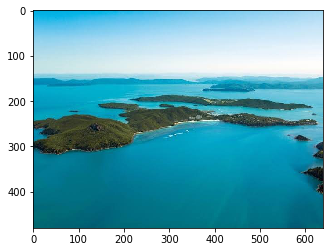

In [15]:
img = mpimg.imread(img_file)
plt.imshow(img)

vec = get_image_vector(img)
print(vec.shape)

In [16]:
import time

t1 = time.time()
neighbours = u.get_nns_by_vector(vec, 20)
t2 = time.time()
print('spend {} second'.format(t2-t1))

spend 0.002200603485107422 second


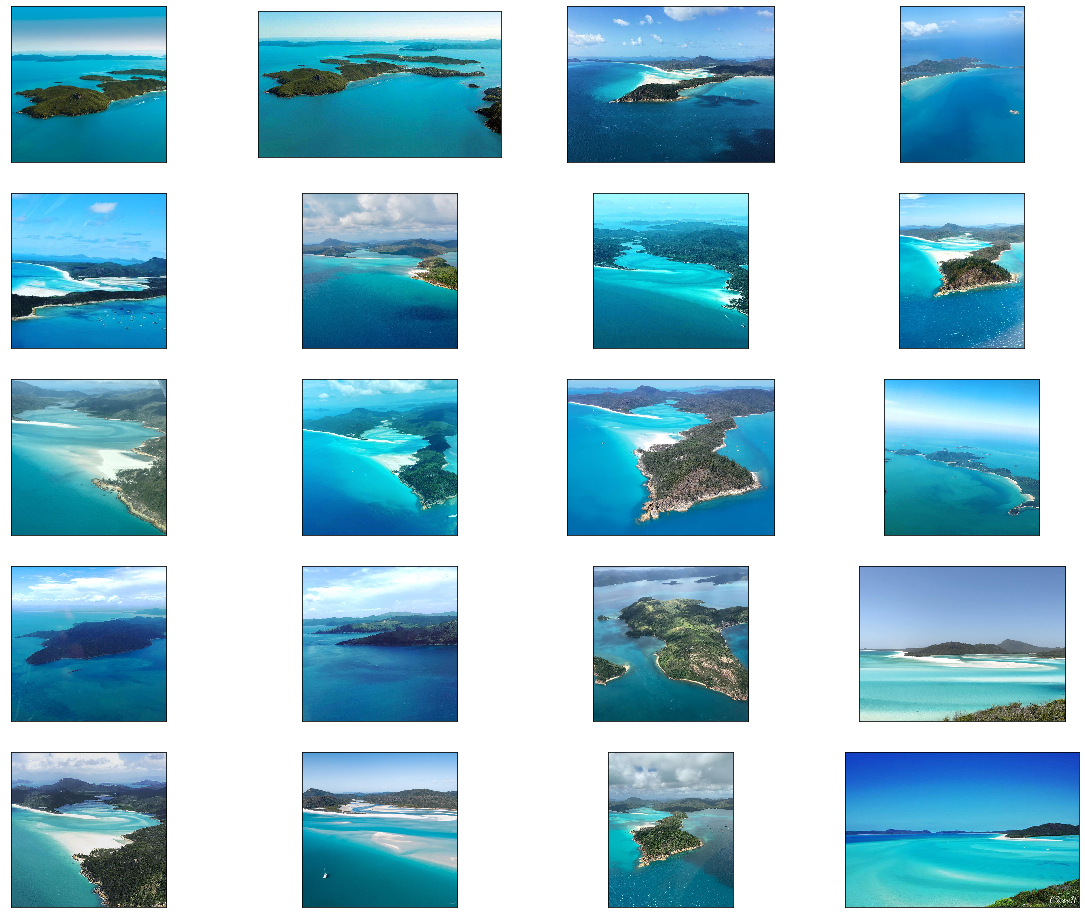

In [17]:
def show_similar_images(neighbours):
    fig = plt.figure(figsize=(20, 20))
    cols = 4
    num_of_images = len(neighbours)
    
    for i, indx in enumerate(neighbours):
        _id = i_to_id[indx]
        ax = fig.add_subplot(num_of_images//cols+1, cols, i+1, xticks=[], yticks=[])
        file = os.path.join('data/all_images', _id + '.jpg')
        img = mpimg.imread(file)
        plt.imshow(img)
        

show_similar_images(neighbours)